In [ ]:
# !pip install --upgrade dabest

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
# import dabest
import matplotlib as mpl
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# sns.set()
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
sns.set_context("paper")


In [19]:

raw_path = [

            # '/content/drive/My Drive/00_project/09_Expresso/lxAop-FLP_Gr64f-lexA/500mM_suc/raw_ts/*',
            # '/content/drive/My Drive/00_project/09_Expresso/u-stop-k21_hiscl1-gal4/500mM_suc/raw_ts/*',
            # '/content/drive/My Drive/00_project/09_Expresso/l-FLP_u-stop-k21_Hiscl1-gal4_Gr64f-lexA/500mM_suc/raw_ts/*',

            # '/content/drive/My Drive/00_project/09_Expresso/lxAop-FLP_Gr64f-lexA/100mM_suc/raw_ts/*',
            # '/content/drive/My Drive/00_project/09_Expresso/u-stop-k21_hiscl1-gal4/100mM_suc/raw_ts/*',
            # '/content/drive/My Drive/00_project/09_Expresso/l-FLP_u-stop-k21_Hiscl1-gal4_Gr64f-lexA/100mM_suc/raw_ts/*',

            '/content/drive/My Drive/00_project/09_Expresso/lxAop-FLP_Gr64f-lexA/20mM_suc/raw_ts/*',
            '/content/drive/My Drive/00_project/09_Expresso/u-stop-k21_hiscl1-gal4/20mM_suc/raw_ts/*',
            '/content/drive/My Drive/00_project/09_Expresso/l-FLP_u-stop-k21_Hiscl1-gal4_Gr64f-lexA/20mM_suc/raw_ts/*',

            # '/content/drive/My Drive/00_project/09_Expresso/{Gr64fG4}{+};{+}{+}/1M_suc/raw/*',
            # '/content/drive/My Drive/00_project/09_Expresso/{UAS-HisCl1-Ri}{+};{+}{+}/1M_suc/raw/*',
            # '/content/drive/My Drive/00_project/09_Expresso/{Gr64fG4}{UAS-HisCl1-Ri};{+}{+}/1M_suc/raw/*',

            # '/content/drive/My Drive/00_project/09_Expresso/{Gr64fG4}{+};{+}{+}/500mM_suc/raw/*',
            # '/content/drive/My Drive/00_project/09_Expresso/{UAS-HisCl1-Ri}{+};{+}{+}/500mM_suc/raw/*',
            # '/content/drive/My Drive/00_project/09_Expresso/{Gr64fG4}{UAS-HisCl1-Ri};{+}{+}/500mM_suc/raw/*',
            ]

In [20]:
raw_path_list = []

for path in raw_path:
    raw_path_list.append(glob.glob(path + '.csv', recursive=True))
raw_path_list

[['/content/drive/My Drive/00_project/09_Expresso/lxAop-FLP_Gr64f-lexA/20mM_suc/raw_ts/231019_flp_Gr64f-lexA_500mMSuc_starved_male_XP03_channel_4_COMBINED_DATA.csv',
  '/content/drive/My Drive/00_project/09_Expresso/lxAop-FLP_Gr64f-lexA/20mM_suc/raw_ts/231019_flp_Gr64f-lexA_500mMSuc_starved_male_XP05_channel_1_COMBINED_DATA.csv',
  '/content/drive/My Drive/00_project/09_Expresso/lxAop-FLP_Gr64f-lexA/20mM_suc/raw_ts/231019_flp_Gr64f-lexA_500mMSuc_starved_male_XP05_channel_2_COMBINED_DATA.csv',
  '/content/drive/My Drive/00_project/09_Expresso/lxAop-FLP_Gr64f-lexA/20mM_suc/raw_ts/231019_flp_Gr64f-lexA_500mMSuc_starved_male_XP05_channel_3_COMBINED_DATA.csv',
  '/content/drive/My Drive/00_project/09_Expresso/lxAop-FLP_Gr64f-lexA/20mM_suc/raw_ts/231019_flp_Gr64f-lexA_500mMSuc_starved_male_XP05_channel_4_COMBINED_DATA.csv',
  '/content/drive/My Drive/00_project/09_Expresso/lxAop-FLP_Gr64f-lexA/20mM_suc/raw_ts/230908_flp_Gr64f-lexA_20mMSuc_starved_male_XP05_channel_1_COMBINED_DATA.csv',
  '/c

In [21]:
import pandas as pd

meal_bout_stack = []
total_ingestion_stack = {}  # Dictionary for total ingestion

for i, sub_paths in enumerate(raw_path_list):
    for j, path in enumerate(sub_paths):
        df = pd.read_csv(path, low_memory=False, skiprows=[0])

        # Exclude rows after 1800 seconds
        df = df[df['Time (s)'] <= 1800]

        # Calculate the consumed volume
        df['Consumed Volume (nL)'] = df['Channel Smoothed (nL)'].diff()

        if (df['Feeding (bool)'] == True).any():
            df['group'] = 'group_' + str(i)
            df['fly'] = 'fly_' + str(j)
            group_fly_key = (df['group'].unique()[0], df['fly'].unique()[0])

            # Initialize total ingestion entry if not exist
            if group_fly_key not in total_ingestion_stack:
                total_ingestion_stack[group_fly_key] = [0, 0, 0]  # total volume, total duration, ingestion rate

            # Find start and end of meal bouts
            start = df[df['Feeding (bool)'].diff()==1].index.values
            end = df[df['Feeding (bool)'].diff()==-1].index.values

            for k in range(len(start)):
                meal_start = start[k]
                meal_end = end[k] if k < len(end) else df.index[-1]  # Handle case where meal doesn't end
                slc_df = df.iloc[meal_start:meal_end]
                meal_len = slc_df['Time (s)'].values[-1] - slc_df['Time (s)'].values[0]
                meal_vol = slc_df['Channel Smoothed (nL)'].values[0] - slc_df['Channel Smoothed (nL)'].values[-1]

                # Update total ingestion values
                total_ingestion_stack[group_fly_key][0] += meal_vol
                total_ingestion_stack[group_fly_key][1] += meal_len

                # Record only the first meal bout
                if k == 0:
                    ingestion_rate_meal = meal_vol / meal_len if meal_len > 0 else 0
                    meal_bout_stack.append([group_fly_key[0], group_fly_key[1], 1, meal_len, meal_vol, ingestion_rate_meal])

# Convert total ingestion stack to DataFrame
for key, value in total_ingestion_stack.items():
    total_volume, total_duration, _ = value
    ingestion_rate_total = total_volume / total_duration if total_duration > 0 else 0
    total_ingestion_stack[key][2] = ingestion_rate_total

total_ingestion_df = pd.DataFrame(total_ingestion_stack.values(), columns=['Total ingested volume (nL)', 'Total meal duration (s)', 'Total ingestion rate (nL/s)'], index=pd.MultiIndex.from_tuples(total_ingestion_stack.keys(), names=['group', 'fly']))
meal_bout_df = pd.DataFrame(meal_bout_stack, columns=['group', 'fly', 'Meal number', 'Meal duration (s)', 'Volume of meal (nL)', 'Ingestion rate (nL/s)'])

print(total_ingestion_df)
print(meal_bout_df)


<ipython-input-21-910a2bcbcb65>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Consumed Volume (nL)'] = df['Channel Smoothed (nL)'].diff()
<ipython-input-21-910a2bcbcb65>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['group'] = 'group_' + str(i)
<ipython-input-21-910a2bcbcb65>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

                Total ingested volume (nL)  Total meal duration (s)  \
group   fly                                                           
group_0 fly_0                   140.244008                80.866667   
        fly_1                   296.247928               213.500000   
        fly_2                   189.670010               133.333333   
        fly_3                   135.295564                96.133333   
        fly_4                   219.918993                93.066667   
...                                    ...                      ...   
group_2 fly_18                  374.445700               167.333333   
        fly_19                  166.256539                88.300000   
        fly_20                  285.137601               165.233333   
        fly_21                  394.295999               223.166667   
        fly_22                  291.312965                91.233333   

                Total ingestion rate (nL/s)  
group   fly                   

In [22]:
fig_title = 'Gr64f_hiscl1_20mM_suc'
base_path = '/content/drive/My Drive/00_project/09_Expresso/' + fig_title
fig_path = base_path + '.csv'
total_ingestion_df.to_csv(fig_path)

fig_title = 'Gr64f_hiscl1_20mM_suc_first_meal'
base_path = '/content/drive/My Drive/00_project/09_Expresso/' + fig_title
fig_path = base_path + '.csv'
meal_bout_df.to_csv(fig_path)

In [10]:
import pandas as pd

meal_bout_stack = []
total_ingestion_stack = []  # Stack for total ingestion

for i, sub_paths in enumerate(raw_path_list):
    for j, path in enumerate(sub_paths):
        df = pd.read_csv(path, low_memory=False, skiprows=[0])

        # Exclude rows after 1800 seconds
        df = df[df['Time (s)'] <= 1800]

        # Calculate the consumed volume
        df['Consumed Volume (nL)'] = df['Channel Smoothed (nL)'].diff()

        if (df['Feeding (bool)'] == True).any():
            df['group'] = 'group_' + str(i)
            df['fly'] = 'fly_' + str(j)
            total_ingested_volume = df[df['Feeding (bool)'] == True]['Consumed Volume (nL)'].sum() * -1
            total_ingestion_stack.append([df['group'].unique()[0], df['fly'].unique()[0], total_ingested_volume])

            # Find start and end of meal bouts
            start = df[df['Feeding (bool)'].diff()==1].index.values
            end = df[df['Feeding (bool)'].diff()==-1].index.values

            # Process only the first meal bout
            if start.size > 0:
                first_meal_start = start[0]
                first_meal_end = end[0] if end.size > 0 else df.index[-1]  # Handle case where meal doesn't end
                slc_df = df.iloc[first_meal_start:first_meal_end]
                group_num = slc_df['group'].unique()[0]
                fly_num = slc_df['fly'].unique()[0]
                meal_len = slc_df['Time (s)'].values[-1] - slc_df['Time (s)'].values[0]
                meal_vol = slc_df['Channel Smoothed (nL)'].values[0] - slc_df['Channel Smoothed (nL)'].values[-1]
                meal_bout_stack.append([group_num, fly_num, 1, meal_len, meal_vol])

meal_bout_df = pd.DataFrame(meal_bout_stack, columns=['group', 'fly', 'Meal number', 'Meal duration (s)', 'Volume of meal (nL)'])
total_ingestion_df = pd.DataFrame(total_ingestion_stack, columns=['group', 'fly', 'Total ingested volume (nL)'])

print(total_ingestion_df)
print(meal_bout_df)


      group     fly  Total ingested volume (nL)
0   group_0   fly_0                  350.198817
1   group_0   fly_1                  215.178090
2   group_0   fly_2                  206.311647
3   group_0   fly_3                  238.811648
4   group_0   fly_4                  247.603852
..      ...     ...                         ...
61  group_2  fly_21                  274.375054
62  group_2  fly_22                  286.155897
63  group_2  fly_23                  338.510462
64  group_2  fly_24                  378.914418
65  group_2  fly_25                  351.301184

[66 rows x 3 columns]
      group     fly  Meal number  Meal duration (s)  Volume of meal (nL)
0   group_0   fly_0            1          40.166667           199.709846
1   group_0   fly_1            1          53.333333           181.918326
2   group_0   fly_2            1          32.100000           120.840368
3   group_0   fly_3            1          60.266667           201.986286
4   group_0   fly_4            1    

In [10]:
meal_bout_stack = []
total_ingestion_stack = []  # Stack for total ingestion

for i, sub_paths in enumerate(raw_path_list):
    for j, path in enumerate(sub_paths):
        df = pd.read_csv(path, low_memory=False, skiprows=[0])

        # Exclude rows after 1800 seconds
        df = df[df['Time (s)'] <= 1800]

        # Calculate the consumed volume
        df['Consumed Volume (nL)'] = df['Channel Smoothed (nL)'].diff()

        if (df['Feeding (bool)'] == True).any():
            df['group'] = 'group_' + str(i)
            df['fly'] = 'fly_' + str(j)
            total_ingested_volume = df[df['Feeding (bool)'] == True]['Consumed Volume (nL)'].sum() * -1
            total_ingestion_stack.append([df['group'].unique()[0], df['fly'].unique()[0], total_ingested_volume])

#             start = df[df['Feeding (bool)'].diff()==1].index.values
#             end = df[df['Feeding (bool)'].diff()==-1].index.values
#             for idx in range(len(start)):
#                 slc_df = df.iloc[start[idx]:end[idx]]
#                 group_num = slc_df['group'].unique()[0]
#                 fly_num = slc_df['fly'].unique()[0]
#                 meal_num = idx+1
#                 meal_len = slc_df['Time (s)'].values[-1] - slc_df['Time (s)'].values[0]
#                 meal_vol = slc_df['Channel Smoothed (nL)'].values[0] - slc_df['Channel Smoothed (nL)'].values[-1]
#                 meal_bout_stack.append([group_num, fly_num, meal_num, meal_len, meal_vol])
# meal_bout_df = pd.DataFrame(meal_bout_stack, columns=['group', 'fly', 'Meal number', 'Meal duration (s)', 'Volume of meal (nL)'])
total_ingestion_df = pd.DataFrame(total_ingestion_stack, columns=['group', 'fly', 'Total ingested volume (nL)'])

print(total_ingestion_df)
# meal_bout_df['ingestion_rate'] = meal_bout_df['Volume of meal (nL)'] / meal_bout_df['Meal duration (s)']
# meal_bout_df

<ipython-input-10-08fda6115d5c>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Consumed Volume (nL)'] = df['Channel Smoothed (nL)'].diff()


      group     fly  Total ingested volume (nL)
0   group_0   fly_0                  275.592147
1   group_0   fly_1                  317.087961
2   group_0   fly_2                  172.863075
3   group_0   fly_3                  321.790271
4   group_0   fly_4                  370.151017
5   group_0   fly_5                  282.540311
6   group_0   fly_6                  400.950073
7   group_0   fly_7                   19.097920
8   group_0   fly_8                  345.132744
9   group_0   fly_9                  263.738001
10  group_0  fly_10                  407.378839
11  group_0  fly_12                  399.507816
12  group_0  fly_13                  252.341590
13  group_0  fly_14                  341.834091
14  group_0  fly_15                  233.442390
15  group_0  fly_16                  147.053922
16  group_0  fly_21                  123.800565
17  group_0  fly_22                  167.614513
18  group_0  fly_26                  196.510416
19  group_0  fly_27                  392

In [ ]:
total_ingestion_df

,group,fly,Total ingested volume (nL)
0,group_0,fly_0,195.379822
1,group_0,fly_1,159.007202
2,group_0,fly_2,135.566500
3,group_0,fly_3,143.463482
4,group_0,fly_4,223.852355
...,...,...,...
58,group_2,fly_18,374.794116
59,group_2,fly_19,166.414395
60,group_2,fly_20,285.453856
61,group_2,fly_21,394.426468


In [ ]:
meal_bout_mean = meal_bout_df.groupby(['group', 'fly']).mean().reset_index().drop('Meal number', axis=1)
fig_title = 'ingestion_rate_SEZ3_NaChBac_500mM-suc'
base_path = '/content/drive/My Drive/01_paper/SEZ3/raw_data/' + fig_title
fig_path = base_path + '.csv'
meal_bout_mean.to_csv(fig_path)

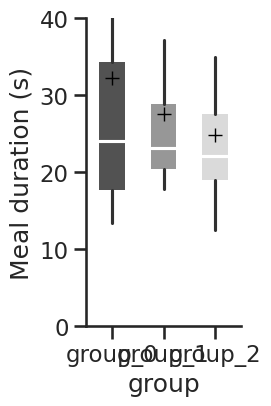

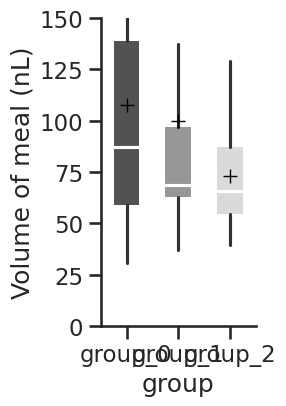

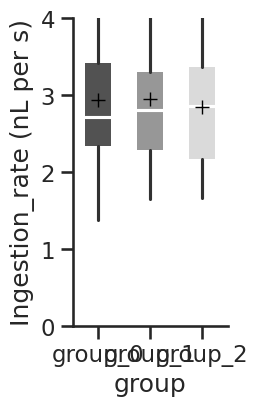

In [ ]:
sns.set_theme(style="ticks")
sns.set_context("talk")

palette_test = sns.color_palette('Greys_r', 3)
palette_control = sns.color_palette('Greys_r', 12)

my_color_palette = {'group_0': palette_test[0],
                    'group_1': palette_test[1],
                    'group_2': palette_test[2],
                    # 'group_3': palette_test[3],
                    # 'group_4': palette_test[4],
                    # 'group_5': palette_test[5],
                    # 'group_6': palette_test[6],
                    # 'group_7': palette_test[7],
                    # 'group_8': palette_test[8],
                    # 'group_9': palette_test[9],
                    # 'group_10': palette_test[10],
                    # 'group_11': palette_test[11],
                    }

PROPS = {
    'boxprops':{'edgecolor':'none'},
    'medianprops':{'color':'white'},
    # 'whiskerprops':{'color':'blue'},
    'capprops':{'color':'none'}
}
column_list = ['Meal duration (s)',
               'Volume of meal (nL)',
               'ingestion_rate']

for c in column_list:

    fig, ax = plt.subplots(figsize=(2,4))

    if c == 'Meal duration (s)':
        ylim = [0, 40]
        ylabel = c

    elif c == 'Volume of meal (nL)':
        ylim = [0, 150]
        ylabel = c

    elif c == 'ingestion_rate':
        ylim = [0, 4]
        ylabel = 'Ingestion_rate (nL per s)'

    sns.boxplot(
                x='group',
                y=c,
                hue='group',
                palette=my_color_palette,
                width=0.5,
                showmeans=True,
                meanprops={"marker":"+",
                       "markeredgecolor":"black",
                       "markersize":"10"},
                showfliers=False,
                # ci=68,
                # scale=0.7,
                dodge=False,
                data=meal_bout_mean,
                ax=ax,
                **PROPS
            )

    ax.set(
        ylim = ylim,
        ylabel=ylabel
    )

    plt.legend([],[], frameon=False)
    sns.despine()

    fig_title = c + '_SEZ3_NaChBac_500mM-suc'
    base_path = '/content/drive/My Drive/01_paper/SEZ3/raw_data/' + fig_title
    fig_path = base_path + '.svg'

    # plt.savefig(fig_path, format='svg' , transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)

    plt.show()

In [ ]:
meal_bout_df[meal_bout_df['Meal number'] == 1]
meal_bout_df['subgroup'] = meal_bout_df['group'] + '_' + meal_bout_df['Meal number'].astype(str)
meal_bout_df['Ingestion rate (nL/s)'] = (meal_bout_df['Volume of meal (nL)'] / meal_bout_df['Meal duration (s)'])

meal_bout_df = meal_bout_df[meal_bout_df['Meal number'] <= 3]
meal_bout_df[meal_bout_df.group=='group_0']['group'] = 'Hdc>GFP-Val10'
meal_bout_df[meal_bout_df.group=='group_1']['group'] = 'Hdc>lovit-RNAi-1'
meal_bout_df[meal_bout_df.group=='group_2']['group'] = 'Hdc>lovit-RNAi-2'
meal_bout_df.to_csv('/content/drive/My Drive/00_project/09_Expresso/figures/l-FLP_u-stop-k21_Hiscl1-gal4_Gr64f-lexA/Expresso_first_meal_bout_output.csv')
meal_bout_df

<ipython-input-16-058abe7c7e6c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meal_bout_df[meal_bout_df.group=='group_0']['group'] = 'Hdc>GFP-Val10'
<ipython-input-16-058abe7c7e6c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meal_bout_df[meal_bout_df.group=='group_1']['group'] = 'Hdc>lovit-RNAi-1'
<ipython-input-16-058abe7c7e6c>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,group,fly,Meal number,Meal duration (s),Volume of meal (nL),ingestion_rate,subgroup,Ingestion rate (nL/s)
0,group_0,fly_1,1,48.166667,203.893246,4.233078,group_0_1,4.233078
1,group_0,fly_2,1,53.333333,181.918326,3.410969,group_0_1,3.410969
2,group_0,fly_2,2,16.000000,33.193465,2.074592,group_0_2,2.074592
3,group_0,fly_6,1,44.133333,174.299274,3.949379,group_0_1,3.949379
4,group_0,fly_6,2,4.000000,6.391664,1.597916,group_0_2,1.597916
...,...,...,...,...,...,...,...,...
227,group_2,fly_49,2,16.100000,18.704329,1.161760,group_2_2,1.161760
228,group_2,fly_49,3,15.066667,17.641435,1.170892,group_2_3,1.170892
231,group_2,fly_50,1,67.266667,247.602134,3.680904,group_2_1,3.680904
232,group_2,fly_50,2,16.033333,10.626064,0.662748,group_2_2,0.662748


<ipython-input-35-9b08301633ae>:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  ax = sns.pointplot(x="subgroup", y=column, ci=68, capsize=0.2,


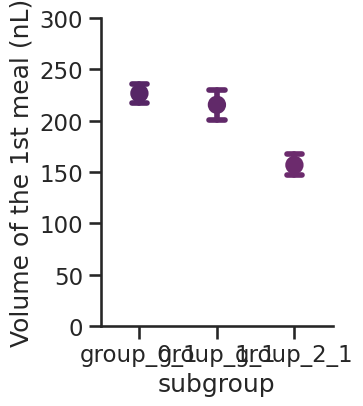

In [ ]:
column = 'Meal duration (s)'
column = 'Ingestion rate (nL/s)'
column = 'Volume of meal (nL)'
color_map = 'flare_r'
num_color = len(meal_bout_df.subgroup.unique())
palette = sns.color_palette(color_map, 20)

my_color_palette = {'group_0_1': palette[0],
                    'group_1_1': palette[1],
                    'group_2_1': palette[2],
                    # 'group_3_1': palette[3],
                    'group_0_2': palette[2],
                    'group_1_2': palette[3],
                    'group_2_2': palette[5],
                    'group_0_3': palette[4],
                    'group_1_3': palette[5],
                    'group_2_3': palette[8],
                    'group_0_4': palette[9],
                    'group_1_4': palette[10],
                    'group_2_4': palette[11],
                    'group_0_5': palette[12],
                    'group_1_5': palette[13],
                    'group_2_5': palette[14],
                        }

order = [ 'group_0_1', 'group_1_1', 'group_2_1',
        #  'group_0_2', 'group_1_2', 'group_2_2',
        #   'group_0_3', 'group_1_3', 'group_2_3',
        #  'group_0_4', 'group_1_4', 'group_0_5', 'group_1_5',
        #  'group_2_1', 'group_3_1'
         ]

fig, ax = plt.subplots(figsize=(3, 4))

ax = sns.pointplot(x="subgroup", y=column, ci=68, capsize=0.2,
                   data=meal_bout_df, join=False, order=order, palette=my_color_palette)

ax.set(
    ylabel="Volume of the 1st meal (nL)",
    ylim=[0, 300]
    )
sns.despine()
fig_title = 'HisCl1_w1118_500mM_suc' + 'each_meal_' + 'volume_first_meal'
base_path = '/content/drive/My Drive/01_paper/HisCl1/raw_data/' + fig_title
stat_path = base_path + '_statistics.csv'
fig_path = base_path  + '.svg'

# multi_groups.mean_diff.statistical_tests.to_csv(stat_path)

# plt.savefig(fig_path, format='svg', transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)

plt.show()

In [ ]:
target_col = 'Volume of meal (nL)'
df_wide=pd.pivot(meal_bout_df,  index='fly', columns ='group' ,values = target_col)
fname = target_col + '_Expresso_w1118_HisCl1-.csv'
# df_wide.columns = ['100mM_w1118', '100mM_HisCl1', '500mM_w1118', '500mM_HisCl1']
# df_wide.to_csv('/content/drive/My Drive/01_paper/HisCl1/raw_data/' + fname)
print(df_wide)

ValueError: ignored

In [ ]:
meal_bout_df.columns

Index(['group', 'fly', 'Meal number', 'Meal duration (s)',
       'Volume of meal (nL)', 'subgroup', 'Ingestion rate (nL/s)'],
      dtype='object')